In [1]:
import sys
from pathlib import Path

# Modify this as you wish, used for importing custom project packages, such as `utils`
project_path = str(Path.home()) + "\\Projects\\rlgym_demo"

sys.path.insert(0, project_path)

In [2]:
import numpy as np
from rlgym.utils import common_values
from utils.analysis.reward_functions import common, extra, custom
from utils.analysis import plotting

In [3]:
ball_position = np.array([4096, 0, 93])

In [4]:
arena_positions = plotting.arena_positions

In [25]:
ball2goal_dist_zs = custom.signed_liu_dist_ball2goal(arena_positions, dispersion=1.1, density=1)

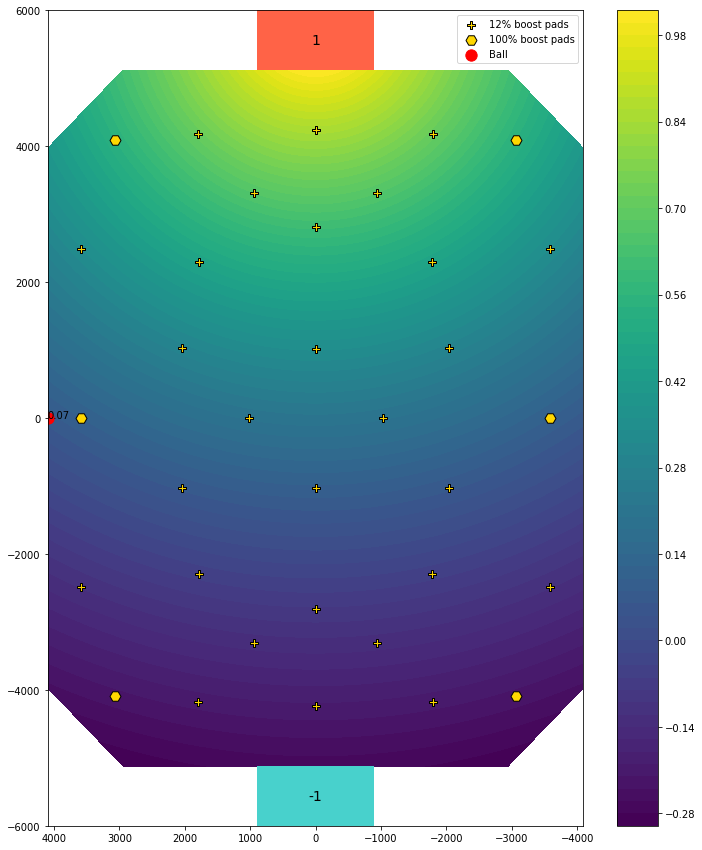

In [26]:
plotting.arena_contour(ball2goal_dist_zs,
                       ball_position=ball_position,
                       annotate_ball=True)

In [1]:
player_positions = np.array([[100, 400, 200], [1200, -600, 300]])

NameError: name 'np' is not defined

In [ ]:
player2ball_dist_zs = custom.liu_dist_player2ball(arena_positions, 
                                                  ball_position,
                                                  dispersion=1,
                                                  density=1)

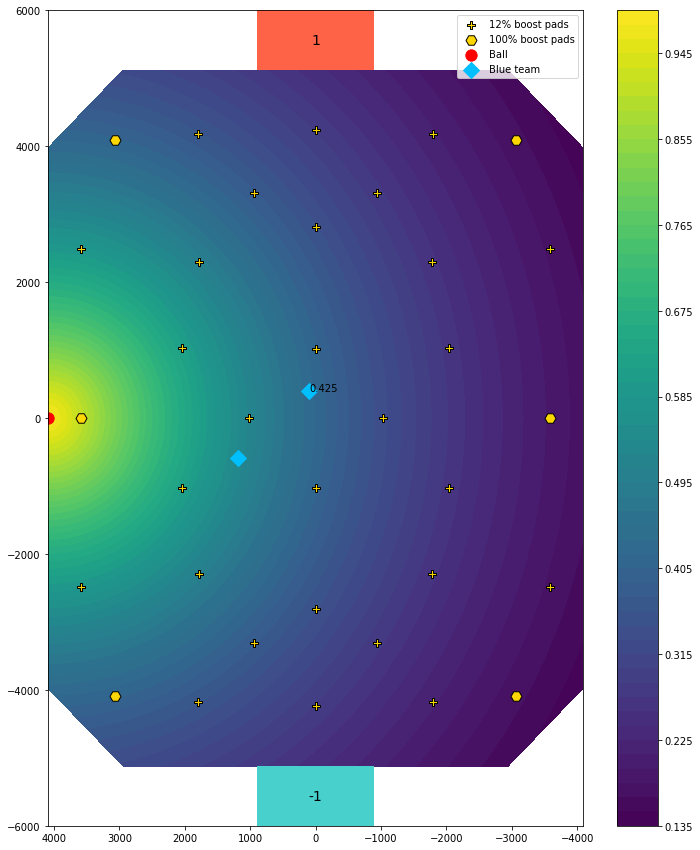

In [9]:
plotting.arena_contour(player2ball_dist_zs,
                      ball_position,
                      player_positions=player_positions)